In [2]:
import sys
from ri_ssim import micro_SSIM
from ri_ssim.CARE_normalization import normalize_CARE, normalize_minmse
from disentangle.core.tiff_reader import load_tiff
import matplotlib.pyplot as plt
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from ri_ssim.ri_ssim import mse_based_range_invariant_structural_similarity, remove_background
from disentangle.analysis.plot_utils import add_pixel_kde, clean_ax, add_subplot_axes, add_text
import os
from matplotlib import patches

def add_text(ax, text, img_shape, place='TOP_LEFT', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 20 / 500, img_shape[0] * 35 / 500, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.9))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500, s1 - s1 * 35 / 500, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.9))




/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-31.tif'
pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-31.tif'
noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/actin-60x-noise2-lowsnr.tif'

# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

In [4]:
debug_mode = True
gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)

In [5]:
from dataclasses import dataclass

@dataclass
class MaxNormalizer:
    factor: float

    def normalize(self, data):
        return data / self.factor



## Obtain dataset level scaling factor

In [6]:
gt_x = remove_background(gt[0])
gt_x2 = remove_background(gt_x)
assert np.all(gt_x == gt_x2), 'Multiple times doing normalization is identity'

In [7]:
from ri_ssim.ri_ssim import get_transformation_params
gt_all_norm = remove_background(gt)
pred_all_norm = remove_background(pred)
all_max = gt_all_norm.max()
normalizer = MaxNormalizer(all_max)

def microSSIM_normalization(data):
    data = remove_background(data)
    return normalizer.normalize(data)


gt_all_norm = normalizer.normalize(gt_all_norm)
pred_all_norm = normalizer.normalize(pred_all_norm)
scaling_factor = get_transformation_params(gt_all_norm[::4], pred_all_norm[::4])
scaling_factor

100%|██████████| 25/25 [00:11<00:00,  2.24it/s]


14.575141519359098

### Multiple ways of data normalization.

In [7]:
idx = np.random.randint(0, gt.shape[0])
print(idx)

# Without any normalization. 
gt_tmp = gt[idx]
pred_tmp = pred[idx]

# mean, std based normalization
gt_norm_meanstd = (gt_tmp - gt_tmp.mean())/gt_tmp.std()
pred_norm_meanstd = (pred_tmp - pred_tmp.mean())/pred_tmp.std()

# CARE based normalization
gt_norm_CARE = normalize_CARE(gt_tmp.copy())
pred_norm_CARE = normalize_minmse(pred_tmp.copy(), gt_norm_CARE)

# Just removing background
pred_norm_bkg = remove_background(pred_tmp.copy())
gt_norm_bkg = remove_background(gt_tmp.copy())

# Background + max normalization == microsim normalization
gt_norm_microssim = normalizer.normalize(gt_norm_bkg)
pred_norm_microssim = normalizer.normalize(pred_norm_bkg)

49


In [8]:
ssim_dict = micro_SSIM(gt_tmp , pred_tmp, ri_factor=1.0, 
                       data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

ssim_dict_meanstd_normalized = micro_SSIM(gt_norm_meanstd , 
                     pred_norm_meanstd, 
                     ri_factor=1.0,  
                     data_range=gt_norm_meanstd.max() - gt_norm_meanstd.min(), return_individual_components=True)

CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE , pred_norm_CARE, 
                                    ri_factor=1.0,
                                    data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)

microssim_bkgnorm_dict = micro_SSIM(gt_norm_bkg , pred_norm_bkg, 
                            ri_factor=scaling_factor,
                            data_range=gt_norm_bkg.max() - gt_norm_bkg.min(), return_individual_components=True)

microssim_dict = micro_SSIM(gt_norm_microssim , pred_norm_microssim, 
                            ri_factor=scaling_factor,
                            data_range=gt_norm_microssim.max() - gt_norm_microssim.min(), return_individual_components=True)

In [9]:
# ssim_dict2 = micro_SSIM(gt_norm_microssim.copy() , pred_norm_microssim.copy(), 
#                             ri_factor=params,
#                             data_range=gt_norm_microssim.max() - gt_norm_microssim.min(), return_individual_components=True)

# ssim_dict3 = micro_SSIM(gt_norm_microssim.copy() , pred_norm_microssim.copy(), 
#                             ri_factor=1.0,
#                             data_range=gt_norm_microssim.max() - gt_norm_microssim.min(), return_individual_components=True)

In [10]:
# _, ax = plt.subplots(figsize=(9,6),ncols=3, nrows=2)
# sns.heatmap(ssim_dict2['luminance'], ax=ax[0,0])
# sns.heatmap(ssim_dict2['contrast'], ax=ax[0,1])
# sns.heatmap(ssim_dict2['structure'], ax=ax[0,2])

# sns.heatmap(ssim_dict3['luminance'], ax=ax[1,0])
# sns.heatmap(ssim_dict3['contrast'], ax=ax[1,1])
# sns.heatmap(ssim_dict3['structure'], ax=ax[1,2])

In [11]:
# microssim_dict_v2 = micro_SSIM(gt_norm_bkg.copy() , pred_norm_bkg,#np.random.rand(*gt_norm.shape),#pred_norm.copy()[::-1], 
#                             ri_factor=params,
#                             data_range=gt_norm_bkg.max() - gt_norm_bkg.min(), return_individual_components=True, K3=0.0)
# microssim_dict_v2['SSIM'].mean(), microssim_dict_v2['luminance'].mean(), microssim_dict_v2['contrast'].mean(), microssim_dict_v2['structure'].mean()

In [12]:
# def get_luminance_factors(tmp_dict):
#     alpha = tmp_dict['alpha']
#     ux = tmp_dict['ux']
#     uy = tmp_dict['uy']
#     num_luminance = (2 * alpha * ux * uy)
#     den_luminance = ux**2 + (alpha**2) * uy**2
#     print(num_luminance.mean()/tmp_dict['C1'], den_luminance.mean()/tmp_dict['C1'])

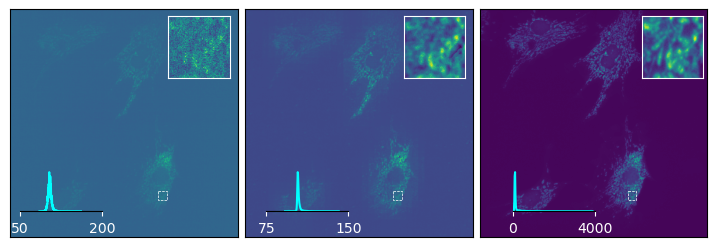

In [13]:
zoomin_sz = 80
save_to_file = False and not debug_mode


def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

def get_zoomin_hw(img):
    hw = None
    hw_std = None
    for _ in range(200):
        h = np.random.randint(0, img.shape[0]-zoomin_sz)
        w = np.random.randint(0, img.shape[1]-zoomin_sz)
        if hw is None:
            hw = [h,w]
            hw_std = img[h:h+80,w:w+80].std()
        else:
            cur_std = img[h:h+80,w:w+80].std()
            if cur_std  > hw_std:
                hw = [h,w]
                hw_std = cur_std
    return hw

_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = get_zoomin_hw(gt[idx])
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4

add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

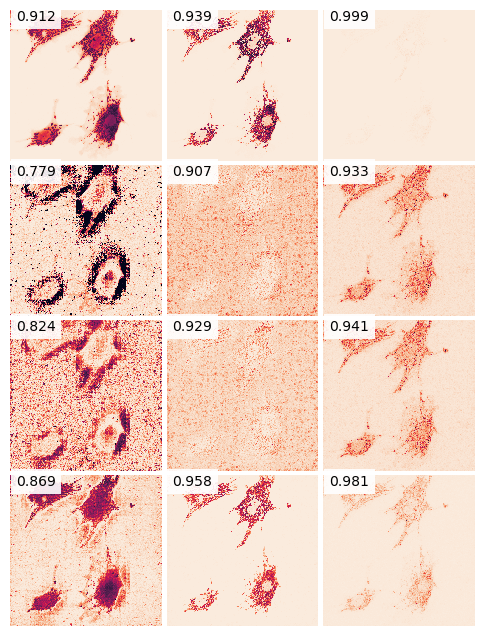

In [14]:
fac = 2 if save_to_file else 4
shape = ssim_dict['luminance'].shape
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3,img_sz*4), ncols=3,nrows=4)

# SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
    val = f"{ssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# SSIM NORMALIZED
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict_meanstd_normalized[key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
    val = f"{ssim_dict_meanstd_normalized[key][::fac,::fac].mean():.3f}"
    add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# CARE-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(CAREssim_carenorm_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[2,i], cbar=False)
    val = f"{CAREssim_carenorm_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[2,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# MICRO-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(microssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[3,i], cbar=False)
    val = f"{microssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[3,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'baseline_comparison_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [15]:
from skimage.metrics import structural_similarity as ssim
# CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE , pred_norm_CARE, ri_factor=1.0, gaussian_weights=True, data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)



In [16]:
normalizer

SyntaxError: invalid syntax (760050616.py, line 1)

## Inspecting individual elements: luminance, contrast and structure

In [20]:
idx_list  = list(range(0,100,33))
idx = idx_list[0]
dicts = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_bkg in [True, False]:
        gt_tmp = normalizer.normalize(remove_background(gt[idx])) if remove_bkg else normalizer.normalize(gt[idx])
        gt_tmp_lowsnr = normalizer.normalize(remove_background(gt_lowsnr[idx])) if remove_bkg else normalizer.normalize(gt_lowsnr[idx])
        pred_tmp = normalizer.normalize(remove_background(pred[idx])) if remove_bkg else normalizer.normalize(pred[idx])
        
        ssim_comp_dict = micro_SSIM(gt_tmp, pred_tmp, ri_factor=None, 
                                    data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        dicts[remove_bkg].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-5

100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


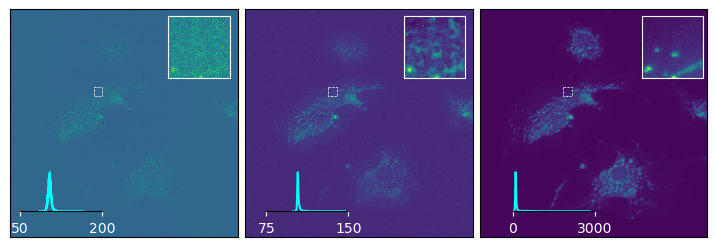

In [23]:

def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

save_to_file = True and not debug_mode
ith_img= 0

idx = idx_list[ith_img]
zoomin_hw = [(700, 750), (1150, 750), (750, 450)][ith_img]
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = zoomin_hw
zoomin_sz = 80
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4
add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])




add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

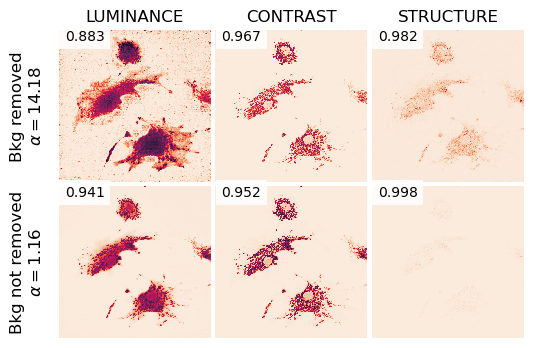

In [24]:
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import os

shape = list(dicts[True][0]['luminance'].shape)
fac = 1 if save_to_file else 4
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3,img_sz*2),ncols=3,nrows=2)

# for idx in range(num_samples):
# For True
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[True][ith_img][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0, i], cbar=False)
    val = f"{dicts[True][ith_img][key][::fac,::fac].mean():.3f}"
    add_text(ax[0, i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# For False
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(dicts[False][ith_img][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1, i], cbar=False)
    val = f"{dicts[False][ith_img][key][::fac,::fac].mean():.3f}"
    add_text(ax[1, i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    ax[0, 0].set_title('Luminance'.upper())
    ax[0, 1].set_title('Contrast'.upper())
    ax[0, 2].set_title('Structure'.upper())


clean_ax(ax)


alpha_true = round(dicts[True][ith_img]['alpha'],2)
ax[0,0].set_ylabel(f'Bkg removed\n$\\alpha={alpha_true}$', fontsize=12)

alpha_false = round(dicts[False][ith_img]['alpha'],2)
ax[1,0].set_ylabel(f'Bkg not removed\n$\\alpha={alpha_false}$', fontsize=12)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)


In [25]:
# import seaborn as sns
# from disentangle.analysis.plot_utils import clean_ax
# import os
# idx = idx_list[0]

# shape = list(dicts[True][idx]['luminance'].shape)
# fac = 1 if save_to_file else 4
# img_sz = 2
# _,ax = plt.subplots(figsize=(img_sz*3,img_sz*2),ncols=3,nrows=2)

# # For True
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
#     val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# # For False
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
#     val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')


# clean_ax(ax)
# ax[0,0].set_title('Luminance'.upper())
# ax[0,1].set_title('Contrast'.upper())
# ax[0,2].set_title('Structure'.upper())

# alpha_true = round(dicts[True][idx]['alpha'],2)
# ax[0,0].set_ylabel('Bkg removed,  ' + f'$\\alpha=${alpha_true}', fontsize=12)

# alpha_false = round(dicts[False][idx]['alpha'],2)
# ax[1,0].set_ylabel('Bkg not removed,  ' + f'$\\alpha=${alpha_false}', fontsize=12)

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'bkg_ablation_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)


### Inspecting background on differently intense pixels

In [26]:
# q_list = [0.01, 0.1, 0.5, 0.9,0.95]
# imgsz = 2
# _,ax = plt.subplots(figsize=(imgsz * len(q_list), imgsz), ncols=len(q_list))
# padx = pady = None
# for ax_idx, q_ in enumerate(q_list):
#     q_val = np.quantile(gt[idx], q_)
#     mask = gt[idx] > q_val
#     ax[ax_idx].imshow(mask)
#     if padx is None:
#         padx, pady = (np.array(mask.shape) - np.array(dicts[True][0]['SSIM'].shape) )//2

#     mask = mask[pady:-pady,padx:-padx]
    
#     ssim_true = 0
#     ssim_false = 0
#     for idx in range(len(dicts[True])):
#         ssim_true += dicts[True][idx]['SSIM'][mask].mean()
#         ssim_false += dicts[False][idx]['SSIM'][mask].mean()
    
#     ssim_true /= len(dicts[True])
#     ssim_false /= len(dicts[False])
#     print(q_,q_val, ssim_true, ssim_false)

# clean_ax(ax)

## Background levels 

In [27]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict, _get_ri_factor
# q_min = 0.1
# idx = np.random.choice(len(gt))
# gt_cur = gt[idx] - np.quantile(gt[idx], q_min)
# pred_cur = pred[idx] - np.quantile(pred[idx], q_min)
# gt_cur[gt_cur < 0] = 0
# pred_cur[pred_cur < 0] = 0

# ssim_dict = structural_similarity_dict(
#     gt_cur,
#     pred_cur,
#     data_range=gt_cur.max() - gt_cur.min())

# ri_factor = _get_ri_factor(ssim_dict)
# ux, uy, vx, vy, vxy, C1, C2 = (
#     ssim_dict["ux"],
#     ssim_dict["uy"],
#     ssim_dict["vx"],
#     ssim_dict["vy"],
#     ssim_dict["vxy"],
#     ssim_dict["C1"],
#     ssim_dict["C2"],
# )
# raw_dict = _ssim_from_params(
#     ri_factor,
#     ux,
#     uy,
#     vx,
#     vy,
#     vxy,
#     C1,
#     C2,
#     return_individual_components=True,
# )

# q_vals = np.quantile(gt_tmp, [0,0.01,0.05,0.1,0.9, 0.95, 0.99])
# for qv in q_vals:
#     mask = gt_cur > np.quantile(gt_cur, qv)


# Manual varying of alpha: inspecting its uniqueness

In [ ]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict
save_to_file = True and not debug_mode

ssim_components = defaultdict(list)
idx_list = []
alpha_list = np.concatenate([np.arange(0,300,1)])
num_idx = 10
for idx in np.random.choice(len(gt), size=num_idx, replace=False):
    idx_list.append(idx)
    gt_cur = microSSIM_normalization(gt[idx])
    pred_cur = microSSIM_normalization(pred[idx])


    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
    
    ssim_components['ssim'].append(ssim_arr)    

100%|██████████| 300/300 [00:08<00:00, 35.67it/s]


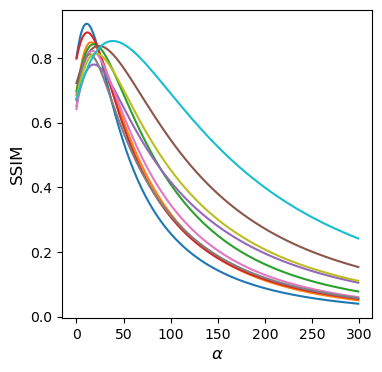

In [ ]:
import pandas as pd
_,ax = plt.subplots(figsize=(4,4))
pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)
ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


# Manual varying of alpha: inspecting the components
Here, we look at 
1. random 
2. flipped. 
3. normal prediction

In [ ]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
# from tqdm import tqdm
# import numpy as np
# from collections import defaultdict

# gt_cur = microSSIM_normalization(gt[idx])
# pred_cur = microSSIM_normalization(pred[idx])
# random_pred = np.random.rand(*gt_cur.shape)
# random_pred = random_pred - random_pred.min()

# pred_list = [pred_cur, pred_cur[::-1], pred_cur[:,::-1], pred_cur[::-1,::-1], random_pred]
# # alpha_list = np.concatenate([np.arange(0.03,20,0.03),np.arange(20,100,0.1), np.arange(100,300,1), np.arange(300,1000,3)])
# alpha_list = np.concatenate([np.arange(0.03,100,0.4)])
# ssim_components = defaultdict(list)

# for pred_tmp in pred_list:
#     ssim_dict = structural_similarity_dict(
#         gt_cur,
#         pred_tmp,
#         data_range=gt_cur.max() - gt_cur.min())

#     ux, uy, vx, vy, vxy, C1, C2 = (
#         ssim_dict["ux"],
#         ssim_dict["uy"],
#         ssim_dict["vx"],
#         ssim_dict["vy"],
#         ssim_dict["vxy"],
#         ssim_dict["C1"],
#         ssim_dict["C2"],
#     )

#     ssim_arr = []
#     luminance_arr = []
#     contrast_arr = []
#     structure_arr = []
#     for factor in tqdm(alpha_list):
#         ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
#         ssim_arr.append(ssim_dict['SSIM'].mean())
#         luminance_arr.append(ssim_dict['luminance'].mean())
#         contrast_arr.append(ssim_dict['contrast'].mean())
#         structure_arr.append(ssim_dict['structure'].mean())
    
#     ssim_components['ssim'].append(ssim_arr)
#     ssim_components['luminance'].append(luminance_arr)
#     ssim_components['contrast'].append(contrast_arr)
#     ssim_components['structure'].append(structure_arr)
    

100%|██████████| 250/250 [00:06<00:00, 36.40it/s]


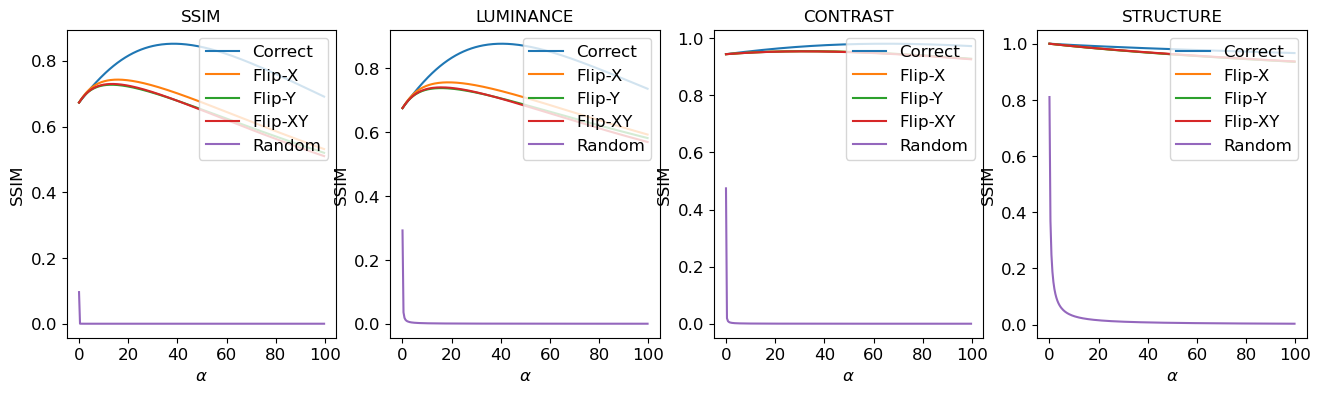

In [ ]:
# import pandas as pd
# import os
# save_to_file = True and not debug_mode

# _,ax = plt.subplots(figsize=(16,4),ncols=4)
# for i, key in enumerate(['ssim','luminance','contrast','structure']):
#     df = pd.DataFrame(np.stack(ssim_components[key]).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
#     df.plot(fontsize=12, ax=ax[i]).legend(loc='upper right', fontsize=12)
#     ax[i].set_title(key.upper(), fontsize=12)

# for i in range(4):
#     ax[i].set_xlabel('$\\alpha$', fontsize=12)
#     ax[i].set_ylabel('SSIM', fontsize=12)

# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'ssim_components_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)

## Experiment to find the utility of division by max value.
1. we want to just show the perofmance on the random test image. and we want to show the performance on the original prediction.
2. we can show a table with SSIM and its 3 components. 
3. We can also show the coefficients vs the components, in both numerator and denominator.

It will be amazing to show the predicted image and the random noise image as well. it will be a pretty convincing figure. 

In [8]:
def luminance_without_C1(alpha, ux, uy):
    num = 2 * alpha * ux * uy
    den = ux**2 + (alpha**2) * uy**2
    return num, den

def contrast_without_C2(alpha, vx, vy):
    num = 2 * alpha * np.sqrt(vx * vy)
    den = vx + (alpha**2) * vy
    return num, den

def structure_without_C2(alpha, vx, vy, vxy):
    num = 2 * alpha * vxy
    den = 2 * alpha * np.sqrt(vx * vy)
    return num, den


def get_multiplicative_factor_to_C(ssim_dict):
    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )
    alpha = ssim_dict['alpha']
    num_luminance, den_luminance = luminance_without_C1(alpha, ux, uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, vx, vy)
    num_structure, den_structure = structure_without_C2(alpha, vx, vy, vxy)

    luminance_factors = (C1/num_luminance.mean(), C1/den_luminance.mean())
    contrast_factors = (C2/num_contrast.mean(), C2/den_contrast.mean())
    structure_factors = (C2/num_structure.mean(), C2/den_structure.mean())
    return luminance_factors, contrast_factors, structure_factors


In [33]:
correct_pred_factorsdict = defaultdict(lambda: defaultdict(list))
random_pred_factorsdict = defaultdict(lambda: defaultdict(list))#defaultdict(list)
for downscale in [True, False]:
    for idx in tqdm(range(len(gt)//10)):
        gt_tmp = normalizer.normalize(remove_background(gt[idx])) if downscale else remove_background(gt[idx])
        pred_tmp = normalizer.normalize(remove_background(pred[idx])) if downscale else remove_background(pred[idx])
        ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                                ri_factor=1.0,
                                data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict)
        
        correct_pred_factorsdict[downscale]['luminance'].append(luminance_factors)
        correct_pred_factorsdict[downscale]['contrast'].append(contrast_factors)
        correct_pred_factorsdict[downscale]['structure'].append(structure_factors)
        correct_pred_factorsdict[downscale]['SSIM'].append(ssim_dict['SSIM'].mean())


    for idx in tqdm(range(len(gt)//10)):
        gt_tmp = normalizer.normalize(remove_background(gt[idx])) if downscale else remove_background(gt[idx])
        pred_tmp = np.random.rand(*gt_tmp.shape)
        ssim_dict = micro_SSIM(gt_tmp , pred_tmp, 
                                ri_factor=1.0,
                                data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict)
        
        random_pred_factorsdict[downscale]['luminance'].append(luminance_factors)
        random_pred_factorsdict[downscale]['contrast'].append(contrast_factors)
        random_pred_factorsdict[downscale]['structure'].append(structure_factors)
        random_pred_factorsdict[downscale]['SSIM'].append(ssim_dict['SSIM'].mean())



100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


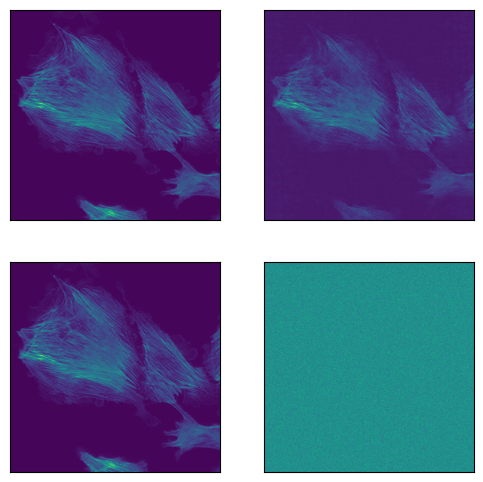

In [36]:
_,ax = plt.subplots(figsize=(img_sz*2,img_sz*2),ncols=2,nrows=2)
ax[0,0].imshow(gt_tmp)
ax[0,1].imshow(normalizer.normalize(remove_background(pred[idx])))
ax[1,0].imshow(gt_tmp)
ax[1,1].imshow(np.random.rand(*gt_tmp.shape))
clean_ax(ax)

In [1]:
from matplotlib.ticker import FormatStrFormatter
img_sz = 3
save_to_file = True and not debug_mode

_,ax = plt.subplots(figsize=(4*img_sz,2*img_sz),ncols=4,nrows=2)
for col_ix, key in enumerate(['luminance', 'contrast', 'structure', 'SSIM']):
    df = pd.DataFrame(correct_pred_factorsdict[True][key]).abs()
    if key != 'SSIM':
        df = df.min(axis=1)
    else:
        assert df.shape[1] == 1
        df = df[0]

    ax[0,col_ix].scatter(df.index, df.values, label='Downscale', color='red')
    df = pd.DataFrame(random_pred_factorsdict[True][key]).abs().min(axis=1)
    ax[1,col_ix].scatter(df.index, df.values, label='Downscale', color='red')
    ax[0,col_ix].set_title(key.upper(), fontsize=12)

    df = pd.DataFrame(correct_pred_factorsdict[False][key]).abs().min(axis=1)
    ax[0,col_ix].scatter(df.index, df.values, label='No Downscale', color='blue', facecolors='none')
    df = pd.DataFrame(random_pred_factorsdict[False][key]).abs().min(axis=1)
    ax[1,col_ix].scatter(df.index, df.values, label='No Downscale', color='blue', facecolors='none')

ax[0,2].legend(loc='upper right', fontsize=10)
plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_downscaling_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

NameError: name 'debug_mode' is not defined

## Experiment on how the offset plays a role in performance

In [ ]:
import numpy as np
from tqdm import tqdm
idx = np.random.randint(0,len(gt))
enable_ri = False
gt_cur = remove_background(gt[idx])
pred_cur = remove_background(pred[idx])
ssim_arr = []
lum_arr = []
con_arr = []
str_arr = []
offset_arr = list(range(-100,300,10))
for offset in tqdm(offset_arr):
    ssim_dict = micro_SSIM(gt_cur + offset , 
                           pred_cur + offset, 
                           ri_factor=None if enable_ri else 1.0, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)
    ssim_arr.append(ssim_dict['SSIM'].mean())
    lum_arr.append(ssim_dict['luminance'].mean())
    con_arr.append(ssim_dict['contrast'].mean())
    str_arr.append(ssim_dict['structure'].mean())

100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


/group/jug/ashesh/ri_ssim/images/bkg_ablation_plot_Idx84_N2V-2402-29.png


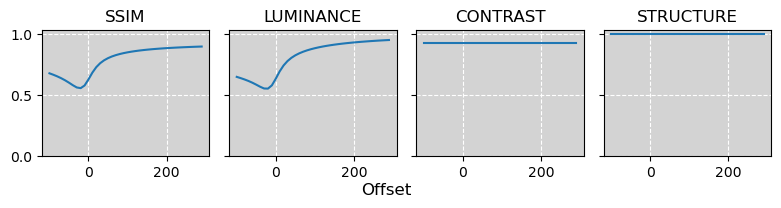

In [ ]:
import matplotlib.pyplot as plt
import os
save_to_file = True and not debug_mode

fig,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].plot(offset_arr,ssim_arr)
ax[1].plot(offset_arr,lum_arr)
ax[2].plot(offset_arr,con_arr)
ax[3].plot(offset_arr,str_arr)
# ax[3].set_yscale('log')
for ax_ in ax:
    # ax_.set_ylim([0.0,1.1])
    ax_.set_ylim([0,1.03])
    ax_.grid(visible=True, color='w', linestyle='--')
    ax_.set_facecolor('lightgrey')

for ax_ in ax[1:]:
    ax_.set_yticklabels([])


plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0].set_title('SSIM')
ax[1].set_title('LUMINANCE')
ax[2].set_title('CONTRAST')
ax[3].set_title('STRUCTURE')

fig.text(0.5, 0.0, 'Offset', ha='center', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


/group/jug/ashesh/ri_ssim/images/luminance_synthetic_plot_Idx84_N2V-2402-29.png


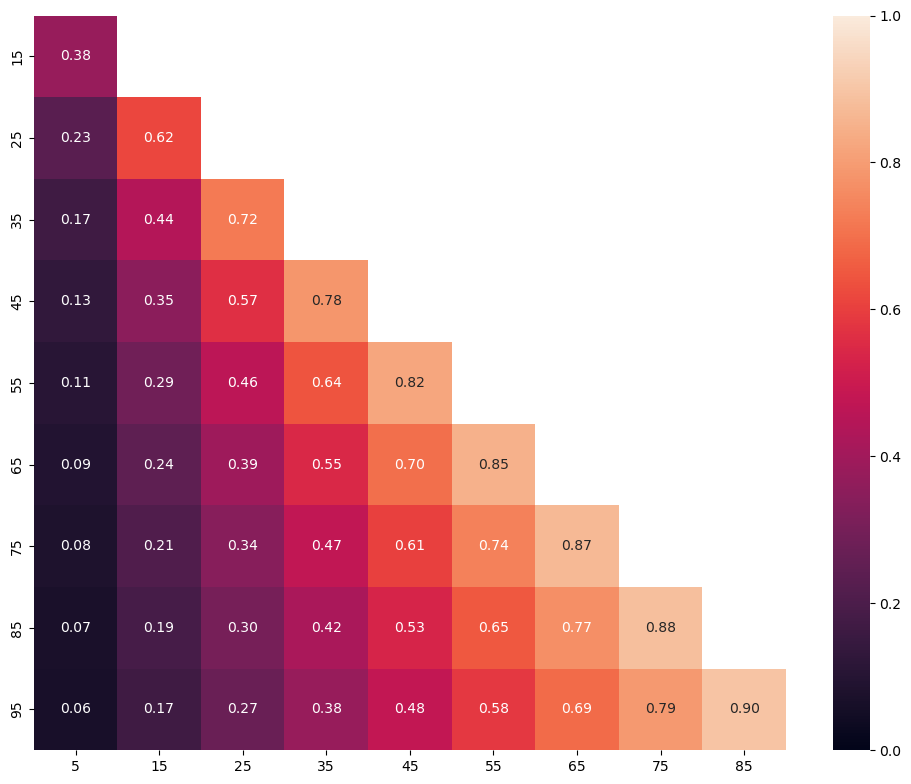

In [ ]:
def compute(numerator_factor, denominator_factor):
    return (1 + numerator_factor)/(1 + denominator_factor)
    
num_factor = np.arange(5, 100, 10)
den_factor = np.arange(5, 100, 10)
num_cor, den_cor = np.meshgrid(num_factor, den_factor)
lum = np.array([compute(num_cor[i], den_cor[i]) for i in range(num_cor.shape[0])])
lum = lum.reshape(len(num_factor),len(num_factor))

# we skip the last numerator and first denominator
lum = lum[1:,:-1]
num_cor = num_cor[1:,:-1]
den_cor = den_cor[1:,:-1]
num_factor = num_factor[:-1]
den_factor = den_factor[1:]
mask = den_cor <= num_cor

import pandas as pd
_, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pd.DataFrame(lum,index=den_factor,columns=num_factor), annot=True, mask=mask,vmin=0,vmax=1, fmt=".2f")
sns.set_theme(style='white')
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'luminance_synthetic_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)
